<a href="https://colab.research.google.com/github/GEJ1/Data-Science-Portfolio/blob/main/TP2_anticoncepcion_Juantorena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">

<h1> <b> TP2: Clasificación (<a href="http://materias.df.uba.ar/lda2021c1/sample-page/">Laboratorio de datos</a>, FCEyN, UBA)</b></h1>

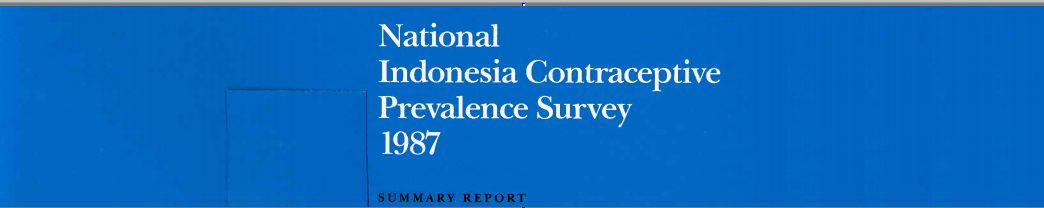
<div>
Dataset: Elección de método anticonceptivo (1987 National Indonesia Contraceptive Prevalence Survey)

Fuentes:

Creador: Tjen-Sien Lim (limt@stat.wisc.edu)
Fecha: 7 de Junio de 1997

Información: 

Este dataset es un subconjunto del 1987 National Indonesia Contraceptive Prevalence Survey.  
Cada sample (fila) representa a una mujer casada que no está embarazada o bien no lo sabe al momento de la entrevista. 

El problema es predecir el uso de anticonceptivos en la muestra (ningún método vs. métodos de corto o largo plazo).

Atributos:

1. Edad de la mujer (numérico)
2. Educación de la mujer (ordinal, 1=bajo, 2, 3, 4=alto)
3. Educación del hombre (ordinal, 1=bajo, 2, 3, 4=alto)
4. Número de hijos nacidos (numérico)
5. Religión de la mujer (binario, 1=Islam, 0= No islam)
6. ¿Trabaja la mujer? (binario, 1=Sí, 0=No)
7. Ocupación del hombre (categórico, 1,2,3,4)
8. Índice de nivel de vida (ordinal, 1=bajo, 2, 3, 4=alto)
9. Exposición a medios (binario, 1=Sí, 0=No)
10. Método anticonceptivo utilizado (categórico, 1=No usa, 2=Largo plazo, 3=Corto plazo)

El objetivo es dicotomizar la variable 10 entre No usa (1) vs. Largo o corto plazo (2 o 3) y predecir la variable binaria resultante.

Para más información sobre el contexto en el cual fueron adquiridos estos datos y su uso visitar https://dhsprogram.com/pubs/pdf/SR9/SR9.pdf
</div>



**Autor**: *Gustavo E. Juantorena* <br>
**Github**: *https://github.com/GEJ1*

### Cargo librerías y monto el Drive

In [ ]:
# Arrays / Linear Algebra
import numpy as np

# Dataframes
import pandas as pd

#Visualizacion
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns

# Para montar drive
from google.colab import drive

# Machine Learning
from sklearn.linear_model import LogisticRegression # El método de regresión logística
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


### Helper functions

In [ ]:
def TPR_FPR(cm): # computa la tasa de verdaderos y falsos positivos a partir de la matriz de confusion
  TPR = cm[1,1]/(cm[1,1]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[0,0])
  return [TPR,FPR] # devuelve una lista donde el primer elemento es la tasa de verdaderos positivos y el segundo la tasa de falsos negativos


def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]


def classifier(X,y,n,c):  # X es la matriz de features, y los labels, n-1 la potencia máxima en la que aparecerán los features, C es la constante de regularización

  # for i in np.arange(2,n):
  #    X = np.concatenate((X,X**i), axis=1)

  X_temp = X
  for i in np.arange(2,n):
      X_temp = np.concatenate((X_temp,X**i), axis=1)
  X = X_temp


  skf = StratifiedKFold(n_splits=20, shuffle=True) # 10 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
  skf.get_n_splits(X, y) # arma los folds a partir de los datos

  auc_train_values = [] # aca es donde van a ir a parar los AUCs train de cada fold
  auc_test_values = [] # aca es donde van a ir a parar los AUCs test de cada fold

  for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
      X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
      y_train, y_test = y[train_index], y[test_index]     # idem con los targets

      # No se si escalear en este caso sea necesario
      scaler = MinMaxScaler() # escaleo por separado ambos sets
      scaler.fit(X_train) 
      X_train = scaler.transform(X_train)

      scaler = MinMaxScaler() # escaleo por separado ambos sets
      scaler.fit(X_test) 
      X_test = scaler.transform(X_test)

      regLog = LogisticRegression(penalty = 'l2',class_weight='balanced', max_iter=10000, solver = 'sag', C=c) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
      regLog.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

      probas_train = regLog.predict_proba(X_train)  # probabilidades con datos de entrenamiento
      probas_test = regLog.predict_proba(X_test)  # probabilidades con datos de evaluación
      fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
      auc_train = roc_auc_score(y_train, probas_train[:,1]) #  AUC con datos de entrenamiento
      auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
      auc_train_values.append(auc_train)
      auc_test_values.append(auc_test)


  return np.mean(auc_train_values), np.mean(auc_test_values)





In [ ]:
# Montamos drive
drive.mount('/content/drive', force_remount=True) # Montamos nuestra unidad de Google Drive

Mounted at /content/drive


### Cargo datos

In [ ]:
# Directamente desde el csv 
path = '/content/drive/My Drive/Colab Notebooks/anticoncepcion_indonesia.csv'
df = pd.read_csv(path)

In [ ]:
df.head(15)

,edad_mujer,educacion_mujer,educacion_hombre,numero_hijos,religion_mujer,mujer_trabaja,ocupacion_hombre,nivel_vida,exposicion_medios,metodo_anticonceptivo
0,35,3,4,3,1,1,2,2,0,2
1,29,4,4,3,1,1,1,4,0,2
2,21,4,4,1,1,1,2,3,0,3
3,26,3,4,3,1,1,3,2,0,3
4,45,3,4,6,1,1,2,4,0,1
5,41,1,3,10,1,1,2,3,1,1
6,26,2,2,4,1,1,3,4,0,2
7,26,3,4,1,1,0,4,1,0,1
8,34,3,4,4,1,1,1,3,0,3
9,42,2,3,2,1,1,1,4,0,1


In [ ]:
# Reemplazo 2 y 3 por 1, y 1 por 0 en metodo_anticonceptivo
# Entonces queda: 
#  1 = Usa anticonceptivo de corto o largo plazo
#  0 = No usa anticoncepcion
df['metodo_anticonceptivo'] = df['metodo_anticonceptivo'].replace(1, 0)
df['metodo_anticonceptivo'] = df['metodo_anticonceptivo'].replace(2, 1)
df['metodo_anticonceptivo'] = df['metodo_anticonceptivo'].replace(3, 1)

In [ ]:
df.head(10)

,edad_mujer,educacion_mujer,educacion_hombre,numero_hijos,religion_mujer,mujer_trabaja,ocupacion_hombre,nivel_vida,exposicion_medios,metodo_anticonceptivo
0,35,3,4,3,1,1,2,2,0,1
1,29,4,4,3,1,1,1,4,0,1
2,21,4,4,1,1,1,2,3,0,1
3,26,3,4,3,1,1,3,2,0,1
4,45,3,4,6,1,1,2,4,0,0
5,41,1,3,10,1,1,2,3,1,0
6,26,2,2,4,1,1,3,4,0,1
7,26,3,4,1,1,0,4,1,0,0
8,34,3,4,4,1,1,1,3,0,1
9,42,2,3,2,1,1,1,4,0,0


In [ ]:
# # One hot encoding en la ocupacion del hombre
# # No se si conviene usar esto o el metodo de sklearn [REVISARRRRRRRR] !!!

# dummy = pd.get_dummies(df.ocupacion_hombre)
# dummy.columns = ['trabajo1','trabajo2','trabajo3','trabajo4']


In [ ]:
# One hot encoding en la ocupacion del hombre
# No se si conviene usar esto o el metodo de sklearn [REVISARRRRRRRR] !!!
dummy = pd.get_dummies(df.ocupacion_hombre)
dummy.columns = ['trabajo1','trabajo2','trabajo3','trabajo4']

# LO junto con el df original
df = pd.concat([df,dummy], axis='columns')

# Dropeo la columna que separe en dummies
df.drop('ocupacion_hombre',axis=1,inplace = True)

In [ ]:
# # LO junto con el df original
# df = pd.concat([df,dummy], axis='columns')

In [ ]:
# # Dropeo la columna que separe en dummies
# df.drop('ocupacion_hombre',axis=1,inplace = True)

In [ ]:
df

,edad_mujer,educacion_mujer,educacion_hombre,numero_hijos,religion_mujer,mujer_trabaja,nivel_vida,exposicion_medios,metodo_anticonceptivo,trabajo1,trabajo2,trabajo3,trabajo4
0,35,3,4,3,1,1,2,0,1,0,1,0,0
1,29,4,4,3,1,1,4,0,1,1,0,0,0
2,21,4,4,1,1,1,3,0,1,0,1,0,0
3,26,3,4,3,1,1,2,0,1,0,0,1,0
4,45,3,4,6,1,1,4,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,29,2,3,1,1,1,1,0,0,1,0,0,0
292,38,4,4,5,1,1,3,0,1,0,1,0,0
293,47,4,4,8,1,1,4,0,1,1,0,0,0
294,44,3,4,2,1,1,4,1,0,1,0,0,0


In [ ]:
# Chequeo dimensiones
df.shape

(296, 13)

In [ ]:
# Correr esta celda si queres ver todos las filas del df

pd.set_option('display.max_rows', None)

In [ ]:
# Estadistica basica
df.describe()

,edad_mujer,educacion_mujer,educacion_hombre,numero_hijos,religion_mujer,mujer_trabaja,nivel_vida,exposicion_medios,metodo_anticonceptivo,trabajo1,trabajo2,trabajo3,trabajo4
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,32.408784,3.016892,3.462838,3.179054,0.888514,0.746622,3.165541,0.067568,0.557432,0.317568,0.293919,0.368243,0.020270
std,8.164316,0.975836,0.810087,2.259076,0.315267,0.435682,0.972309,0.251427,0.497532,0.466319,0.456327,0.483145,0.141162
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,2.000000,3.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,39.000000,4.000000,4.000000,4.000000,1.000000,1.000000,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,49.000000,4.000000,4.000000,13.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   edad_mujer             296 non-null    int64
 1   educacion_mujer        296 non-null    int64
 2   educacion_hombre       296 non-null    int64
 3   numero_hijos           296 non-null    int64
 4   religion_mujer         296 non-null    int64
 5   mujer_trabaja          296 non-null    int64
 6   nivel_vida             296 non-null    int64
 7   exposicion_medios      296 non-null    int64
 8   metodo_anticonceptivo  296 non-null    int64
 9   trabajo1               296 non-null    uint8
 10  trabajo2               296 non-null    uint8
 11  trabajo3               296 non-null    uint8
 12  trabajo4               296 non-null    uint8
dtypes: int64(9), uint8(4)
memory usage: 22.1 KB


In [ ]:
df.columns

Index(['edad_mujer', 'educacion_mujer', 'educacion_hombre', 'numero_hijos',
       'religion_mujer', 'mujer_trabaja', 'nivel_vida', 'exposicion_medios',
       'metodo_anticonceptivo', 'trabajo1', 'trabajo2', 'trabajo3',
       'trabajo4'],
      dtype='object')

Sin anticoncepcion 131
Con anticoncepcion 165


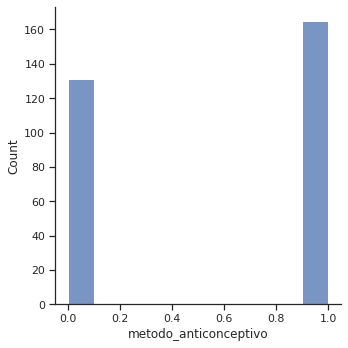

In [ ]:
# Filtro y observo las clases (con anticoncepcion Vs. Sin anticoncepcion)
cant_mujeres_sin_anticoncepcion = len(df[df['metodo_anticonceptivo'] == 0])
cant_mujeres_con_anticoncepcion = len(df[df['metodo_anticonceptivo'] == 1])

print('Sin anticoncepcion', cant_mujeres_sin_anticoncepcion)
print('Con anticoncepcion', cant_mujeres_con_anticoncepcion)

sin_anticoncepcion = df[df['metodo_anticonceptivo'] == 0]
con_anticoncepcion = df[df['metodo_anticonceptivo'] == 1]

sns.set_theme(style="ticks", color_codes=True)
sns.displot(data=df, x="metodo_anticonceptivo")


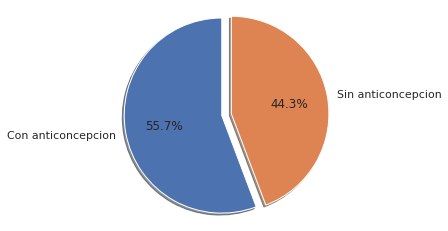

In [ ]:
# Los datos estan levemente desbalanceados
prop_sin = cant_mujeres_sin_anticoncepcion / df.shape[0] * 100
prop_con = cant_mujeres_con_anticoncepcion / df.shape[0] * 100

labels = 'Con anticoncepcion', 'Sin anticoncepcion'
sizes = [prop_con,prop_sin]
explode = (0, 0.1) # 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
df.shape

(296, 13)

In [ ]:
# Cuantos NaN hay en el df ---> NINGUNO
count_nan = len(df) - df.count()
count_nan

edad_mujer               0
educacion_mujer          0
educacion_hombre         0
numero_hijos             0
religion_mujer           0
mujer_trabaja            0
nivel_vida               0
exposicion_medios        0
metodo_anticonceptivo    0
trabajo1                 0
trabajo2                 0
trabajo3                 0
trabajo4                 0
dtype: int64

In [ ]:
# Valores unicos en cada columna.
df.nunique()

edad_mujer               34
educacion_mujer           4
educacion_hombre          4
numero_hijos             13
religion_mujer            2
mujer_trabaja             2
nivel_vida                4
exposicion_medios         2
metodo_anticonceptivo     2
trabajo1                  2
trabajo2                  2
trabajo3                  2
trabajo4                  2
dtype: int64

In [ ]:
# Tipos de datos en el df ---> TODOS ENTEROS
df.dtypes

edad_mujer               int64
educacion_mujer          int64
educacion_hombre         int64
numero_hijos             int64
religion_mujer           int64
mujer_trabaja            int64
nivel_vida               int64
exposicion_medios        int64
metodo_anticonceptivo    int64
trabajo1                 uint8
trabajo2                 uint8
trabajo3                 uint8
trabajo4                 uint8
dtype: object

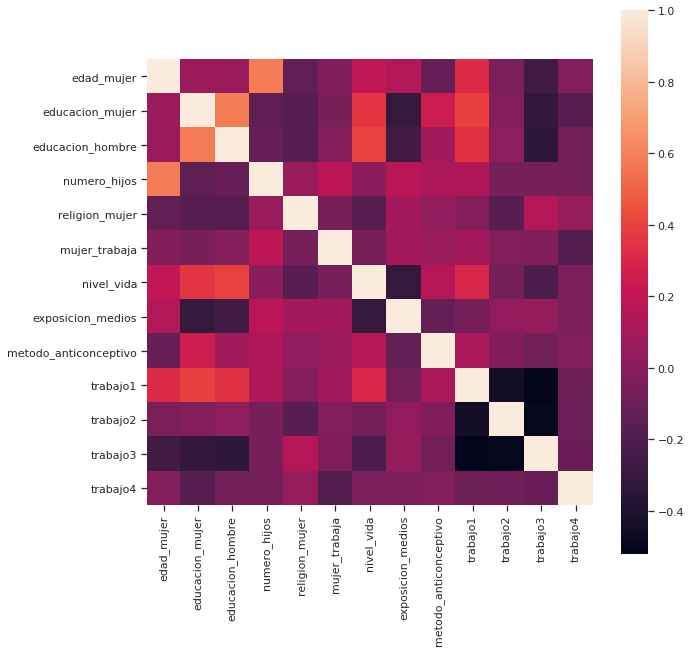

In [ ]:
# Ploteo correlaciones entre variables 

fig, ax = plt.subplots(1,1, figsize=(10,10)) 
# calculate the correlation matrix
corr = df.corr() 

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=True)

In [ ]:
# Posible nuevo feature : tiene_hijos , feature binario con 1 si tiene y 0 si no tiene
df['tiene_hijos']= (df['numero_hijos'] != 0).astype('int')

### Modelo: Regresion logistica

In [ ]:
df.columns

Index(['edad_mujer', 'educacion_mujer', 'educacion_hombre', 'numero_hijos',
       'religion_mujer', 'mujer_trabaja', 'nivel_vida', 'exposicion_medios',
       'metodo_anticonceptivo', 'trabajo1', 'trabajo2', 'trabajo3', 'trabajo4',
       'tiene_hijos'],
      dtype='object')

In [ ]:
features = list(df.columns)
features.remove('metodo_anticonceptivo') # Saco la columna target
features

['edad_mujer',
 'educacion_mujer',
 'educacion_hombre',
 'numero_hijos',
 'religion_mujer',
 'mujer_trabaja',
 'nivel_vida',
 'exposicion_medios',
 'trabajo1',
 'trabajo2',
 'trabajo3',
 'trabajo4',
 'tiene_hijos']

In [ ]:
# Probando con cada uno de los features individualmente y guardo los scores en un diccionario


score_feat_individual = dict() # Diccionario de features / score
for feati in features:
  X = df[feati].values.reshape(-1,1) # Defino la variable X (los features). El método .values, me lleva la Serie de pandas a un array de numpy. El .reshape(-1,1) es para llevarlo a la forma matricial que le gusta a sklearn 
  y = df['metodo_anticonceptivo'] # Defino la variable y

  regLog = LogisticRegression(penalty = 'none')   # creamos el objeto classificador. Usamos todo por defecto, excepto que no vamos a usar regularizacion y por eso lo aclaramos
  # ahora entrenamos el modelo usando el metodo .fit(X,y) donde X es la matriz de features (dias x variable independiente) e y es el vector de etiquetas (0 si no llueve, 1 si llueve)

  regLog.fit(X,  y)

  score = regLog.score(X,y) # Es el score del ajuste 

  beta_0 = regLog.intercept_ # Es el método para obtener el beta 0
  beta_1 = regLog.coef_ # Es el método para obtener el beta 1

  print(f'El score del modelo usando solo el campo [{feati}] es de: {round(score,4)}\n') # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
  score_feat_individual[f'{feati}'] = score

El score del modelo usando solo el campo [edad_mujer] es de: 0.6115

El score del modelo usando solo el campo [educacion_mujer] es de: 0.6182

El score del modelo usando solo el campo [educacion_hombre] es de: 0.5642

El score del modelo usando solo el campo [numero_hijos] es de: 0.6318

El score del modelo usando solo el campo [religion_mujer] es de: 0.5574

El score del modelo usando solo el campo [mujer_trabaja] es de: 0.5574

El score del modelo usando solo el campo [nivel_vida] es de: 0.5811

El score del modelo usando solo el campo [exposicion_medios] es de: 0.5845

El score del modelo usando solo el campo [trabajo1] es de: 0.5574

El score del modelo usando solo el campo [trabajo2] es de: 0.5574

El score del modelo usando solo el campo [trabajo3] es de: 0.5574

El score del modelo usando solo el campo [trabajo4] es de: 0.5574

El score del modelo usando solo el campo [tiene_hijos] es de: 0.6081



In [ ]:
# Ordeno los valores del dict de mayor a menor en base a su score

score_feat_individual = sorted(((value,key) for (key,value) in score_feat_individual.items()), reverse=True)

In [ ]:
# Probando con todos los features juntos

X = df[features].values # Defino la variable X (los features). El método .values, me lleva la Serie de pandas a un array de numpy. El .reshape(-1,1) es para llevarlo a la forma matricial que le gusta a sklearn 
y = df['metodo_anticonceptivo'] # Defino la variable y

regLog = LogisticRegression(penalty = 'none')   # creamos el objeto classificador. Usamos todo por defecto, excepto que no vamos a usar regularizacion y por eso lo aclaramos
# ahora entrenamos el modelo usando el metodo .fit(X,y) donde X es la matriz de features (dias x variable independiente) e y es el vector de etiquetas (0 si no llueve, 1 si llueve)

regLog.fit(X,  y)

score = regLog.score(X,y) # Es el score del ajuste 

beta_0 = regLog.intercept_ # Es el método para obtener el beta 0
beta_1 = regLog.coef_ # Es el método para obtener el beta 1

print(f'El score del modelo usando todos los campos es de: {round(score,4)}\n') # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas

ypred = regLog.predict(X)
print(len(ypred))

El score del modelo usando todos los campos es de: 0.7128

296


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Odeno los features en base a su score individual

score_feat_individual[1][1]

features = [i[1] for i in score_feat_individual]
features

['numero_hijos',
 'educacion_mujer',
 'edad_mujer',
 'tiene_hijos',
 'exposicion_medios',
 'nivel_vida',
 'educacion_hombre',
 'trabajo4',
 'trabajo3',
 'trabajo2',
 'trabajo1',
 'religion_mujer',
 'mujer_trabaja']

In [ ]:
# Probando que pasa si agrego un feature de a uno (del que me daba mejor al que me daba peor score)
scores = []
labels = []
for i in range(len(features)):

  X = df[features[:i+1]].values # Defino la variable X (los features). El método .values, me lleva la Serie de pandas a un array de numpy. El .reshape(-1,1) es para llevarlo a la forma matricial que le gusta a sklearn 
  y = df['metodo_anticonceptivo'] # Defino la variable y

  regLog = LogisticRegression(penalty = 'none')   # creamos el objeto classificador. Usamos todo por defecto, excepto que no vamos a usar regularizacion y por eso lo aclaramos
  # ahora entrenamos el modelo usando el metodo .fit(X,y) donde X es la matriz de features (dias x variable independiente) e y es el vector de etiquetas (0 si no llueve, 1 si llueve)

  regLog.fit(X,  y)

  score = regLog.score(X,y) # Es el score del ajuste 

  beta_0 = regLog.intercept_ # Es el método para obtener el beta 0
  beta_1 = regLog.coef_ # Es el método para obtener el beta 1

  print(f'El score del modelo usando solo los campos [{features[:i+1]}] es de: {round(score,4)}\n') # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
  scores.append(score)
  labels.append(features[:i+1])





El score del modelo usando solo los campos [['numero_hijos']] es de: 0.6318

El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer']] es de: 0.6351

El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer']] es de: 0.7061

El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer', 'tiene_hijos']] es de: 0.7264



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer', 'tiene_hijos', 'exposicion_medios']] es de: 0.7196

El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer', 'tiene_hijos', 'exposicion_medios', 'nivel_vida']] es de: 0.7061

El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer', 'tiene_hijos', 'exposicion_medios', 'nivel_vida', 'educacion_hombre']] es de: 0.7095

El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer', 'tiene_hijos', 'exposicion_medios', 'nivel_vida', 'educacion_hombre', 'trabajo4']] es de: 0.6926

El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer', 'tiene_hijos', 'exposicion_medios', 'nivel_vida', 'educacion_hombre', 'trabajo4', 'trabajo3']] es de: 0.7061

El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer', 'tiene_hijos', 'exposici

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer', 'tiene_hijos', 'exposicion_medios', 'nivel_vida', 'educacion_hombre', 'trabajo4', 'trabajo3', 'trabajo2', 'trabajo1', 'religion_mujer']] es de: 0.7095

El score del modelo usando solo los campos [['numero_hijos', 'educacion_mujer', 'edad_mujer', 'tiene_hijos', 'exposicion_medios', 'nivel_vida', 'educacion_hombre', 'trabajo4', 'trabajo3', 'trabajo2', 'trabajo1', 'religion_mujer', 'mujer_trabaja']] es de: 0.7095



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Hasta aca no tuve en cuenta:

*  Normalizacion
*  max_iter
*  alternative solver options (sol?)
*  Regularizacion (l2 ?)
*  kfold
*  gridsearch
*  tol?
* colinealidad en los trabajos? porque cuando uso 3 posibilidades en vez de las 4 da mejor (summy variable trap?)
* Sacar educacion hombre? Probe a ojo y da mejor
* Classweight ? estan levemente desbalanceados

Revisar la documentacion: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Aplicando lo visto en la clase de seleccion de features

### Reviso los datos


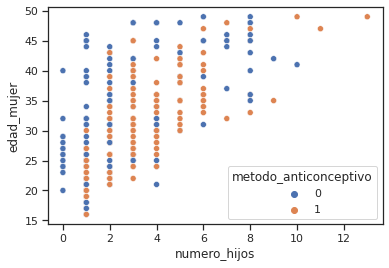

In [ ]:
sns.scatterplot(data=df, x="numero_hijos", y='edad_mujer',  hue="metodo_anticonceptivo")

In [ ]:
(df['religion_mujer'] == 1).sum()

263

In [ ]:
len(df[(df['religion_mujer'] == 1) & (df['metodo_anticonceptivo'] == 1)]) 

148

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


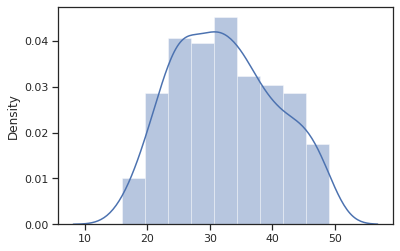

In [ ]:
X = df['edad_mujer'].values.reshape(-1, 1)
sns.distplot(X)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


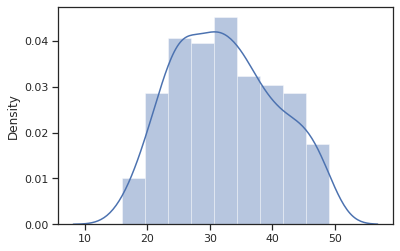

In [ ]:
X = df['edad_mujer'].values.reshape(-1, 1)
#  X[0]

sns.distplot(X)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


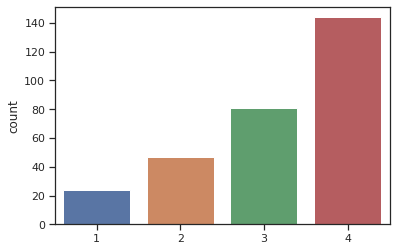

In [ ]:
X = df['nivel_vida'].values
sns.countplot(X)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


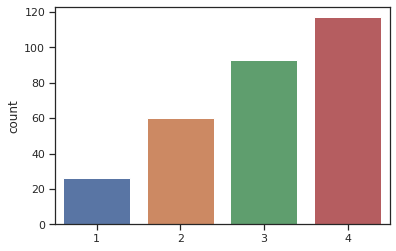

In [ ]:
X = df['educacion_mujer'].values
sns.countplot(X)

numero_hijos
educacion_mujer
edad_mujer
tiene_hijos
exposicion_medios
nivel_vida
educacion_hombre
trabajo4
trabajo3
trabajo2
trabajo1
religion_mujer
mujer_trabaja


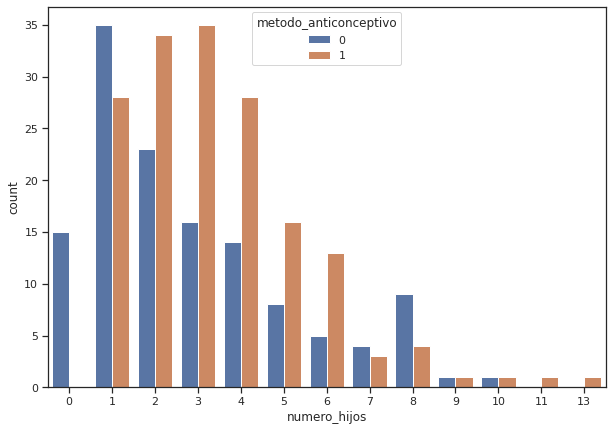

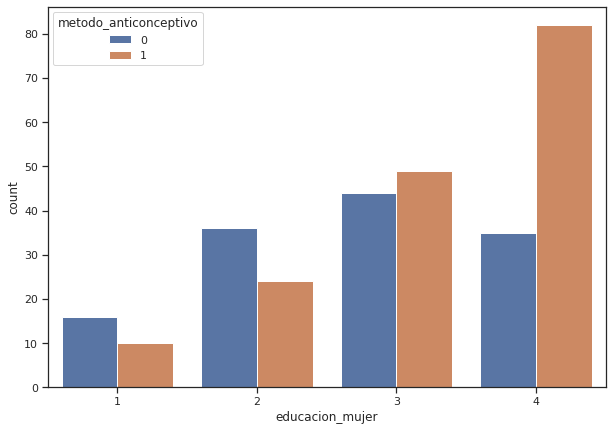

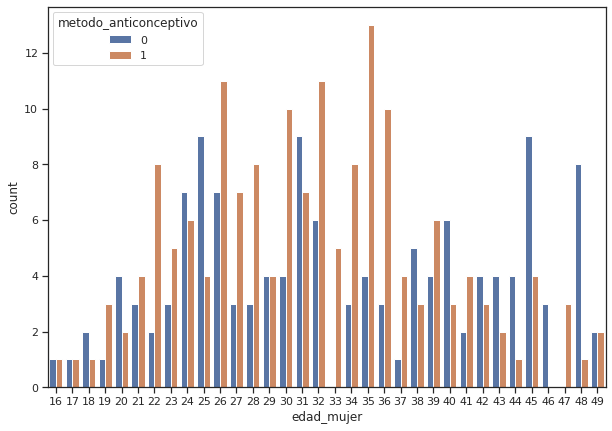

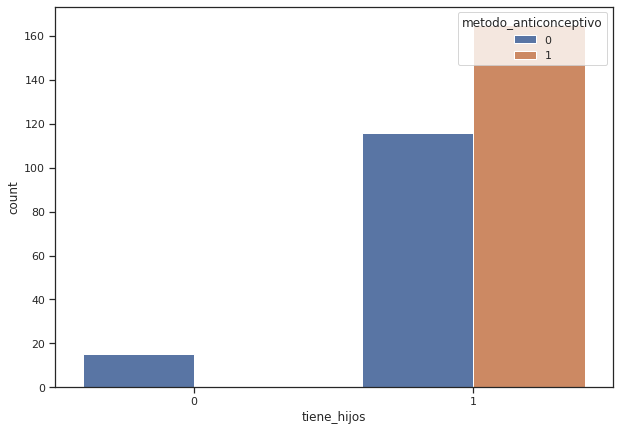

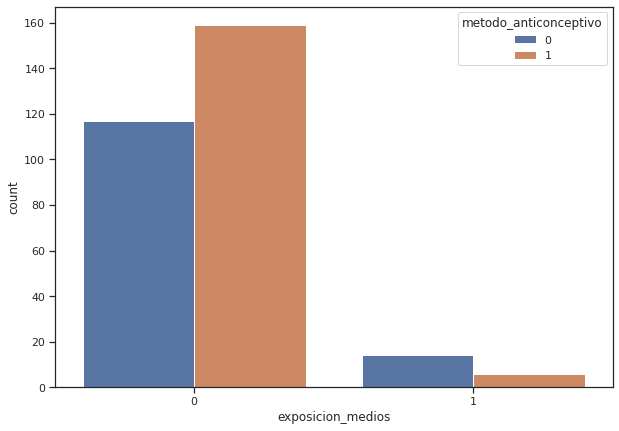

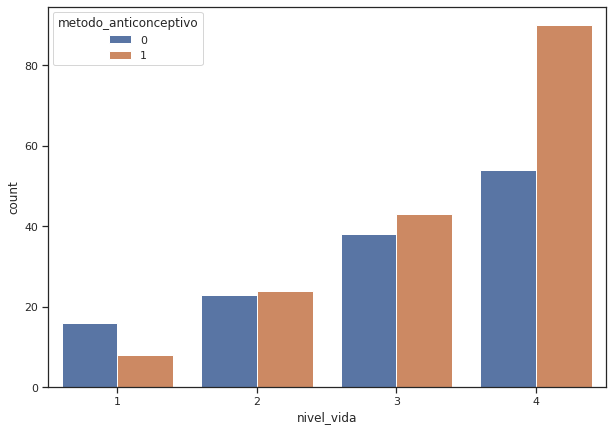

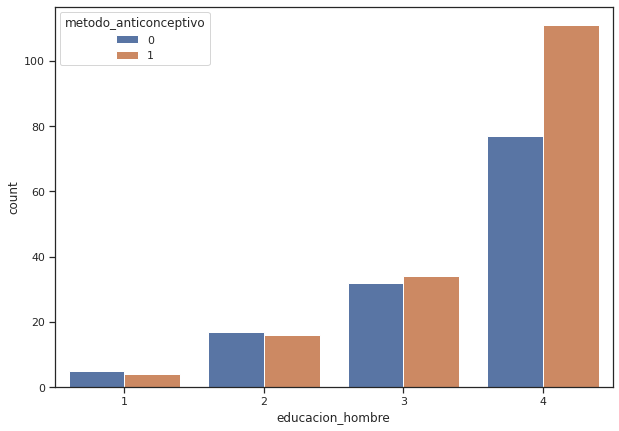

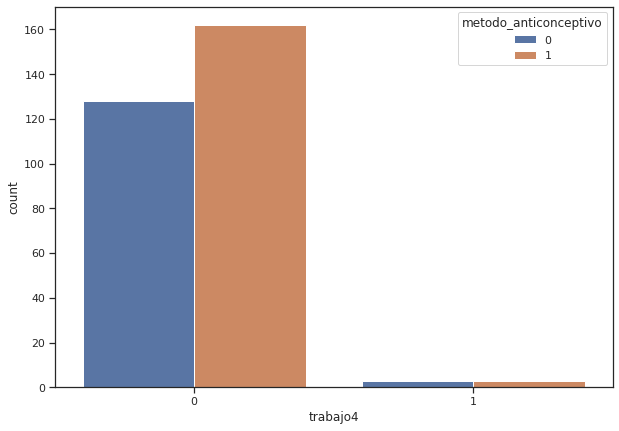

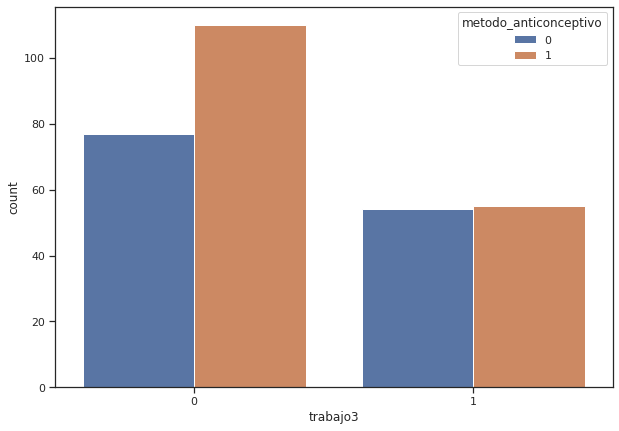

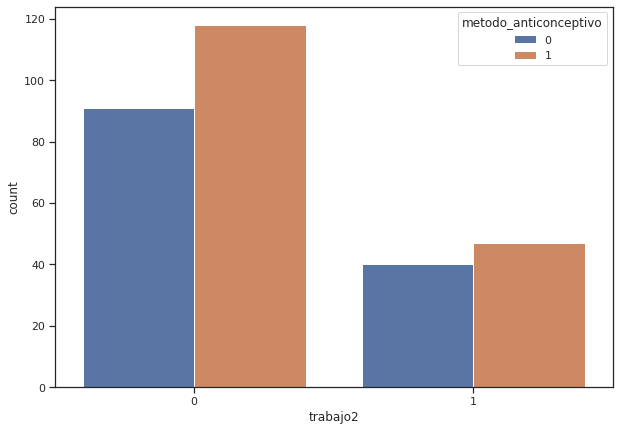

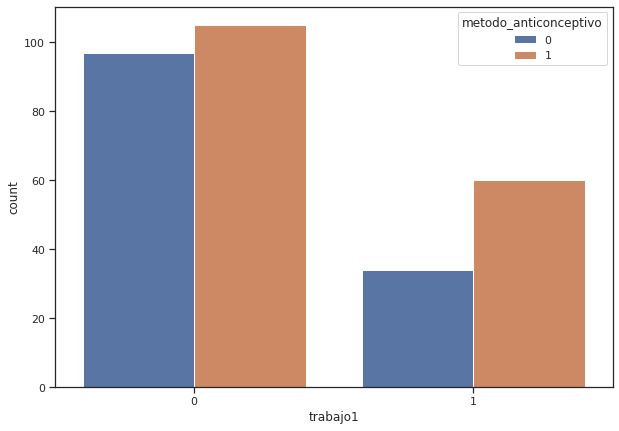

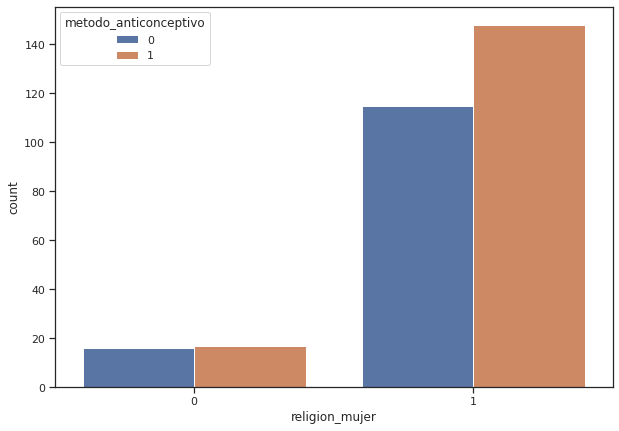

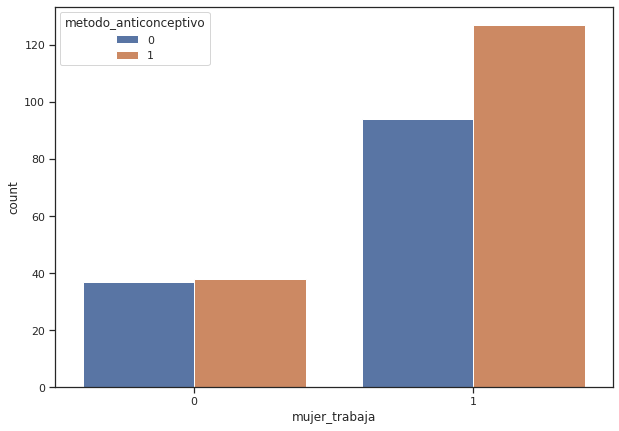

In [ ]:
# Recorro todos los features y busco diferencias en base a la variable "metodo_anticonceptivo"
for feati in features:
  print(feati)
  fig, ax = plt.subplots(figsize = (10,7))
  sns.countplot(x=feati,hue='metodo_anticonceptivo', data=df)
  plt.show

In [ ]:
df['edad_mujer'].max()

49

In [ ]:
# Aca estaba buscando si podria tener un punto de corte en cierta edad de la mujer para crear un nuevo feature, pero no me pareció útil
edad = 25
len(df[(df['edad_mujer'] < edad) & (df['metodo_anticonceptivo'] == 1)]) / len(df[(df['edad_mujer'] < edad)])

0.5636363636363636

###  Probando modelos utilizando cross validation


### Defino los features que voy a usar

In [ ]:
features = list(df.columns)
features.remove('metodo_anticonceptivo') # Saco la columna target
features.remove('religion_mujer') # No parece ser muy informativo pero no se si sacarlo
features.remove('educacion_hombre') # Puede estar explicada por nivel de vida (corr positiva) y exposicion a los medios (corr negativa)
features.remove('trabajo4') # Saco uno de las dummy para que no se pueda deducir una columna de las otras 3 (evito colinealidad)
# features.remove('exposicion_medios') #Negativamente correlacionada con exposicion a los medios
features

['edad_mujer',
 'educacion_mujer',
 'numero_hijos',
 'mujer_trabaja',
 'nivel_vida',
 'exposicion_medios',
 'trabajo1',
 'trabajo2',
 'trabajo3',
 'tiene_hijos']

In [ ]:
# Usando train-test split y stratified K fold

# Hasta ahora la forma en que mejor dar (~0.75 en test) es:
#   estos features ['edad_mujer', 'educacion_mujer', 'numero_hijos','religion_mujer', 'mujer_trabaja', 'nivel_vida', 'exposicion_medios', 'trabajo1', 'trabajo2', 'trabajo3','tiene_hijos'],
#   o sea sacando: educacion_hombre, trabajo4; y agregando: 'tiene_hijos'
# penalty = 'l2'
# solver = 'sag'
# C = 3.55?
# X**2
# class_weight='balanced'
# scaler = StandardScaler

todos_los_AUC_promedio = []

# Corro 100 veces el clasificador para tener un dato mas preciso, en cada iteracion se hace el cross validation

for i in range(100):
  X = df[features].values # Defino la variable X (los features). El método .values, me lleva la Serie de pandas a un array de numpy. 
  y = df['metodo_anticonceptivo'] # Defino la variable y

  X = np.concatenate((X, X**2), axis=1) # agrego features elevados a potencias
  # poly = PolynomialFeatures(2)
  # poly.fit_transform(X) 

  skf = StratifiedKFold(n_splits=5, shuffle=True) # 10 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
  skf.get_n_splits(X, y) # arma los folds a partir de los datos

  auc_train_values = [] # aca es donde van a ir a parar los AUCs train de cada fold
  auc_test_values = [] # aca es donde van a ir a parar los AUCs test de cada fold

  for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
      X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
      y_train, y_test = y[train_index], y[test_index]     # idem con los targets

      # No se si escalear en este caso sea necesario [CREO QUE SIRVE]
      scaler = StandardScaler() # escaleo por separado ambos sets
      scaler.fit(X_train) 
      X_train = scaler.transform(X_train)

      scaler = StandardScaler() # escaleo por separado ambos sets
      scaler.fit(X_test) 
      X_test = scaler.transform(X_test)

      regLog = LogisticRegression(penalty = 'l2',class_weight='balanced', max_iter=1000000, solver = 'sag', C=3.55) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
      regLog.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

      probas_train = regLog.predict_proba(X_train)  # probabilidades con datos de entrenamiento
      probas_test = regLog.predict_proba(X_test)  # probabilidades con datos de evaluación
      fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
      auc_train = roc_auc_score(y_train, probas_train[:,1]) #  AUC con datos de entrenamiento
      auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación


      # fig, ax = plt.subplots(figsize = (10,7))
      # ax.set_title(f'auc_test: {auc_test}')
      # ax.plot(fpr_test,tpr_test) # Gráfico de TPR vs FPR
      # ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
      # ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

      T = 0.5 # definimos el umbral
      ypred = np.zeros(probas_test.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
      ypred[probas_test[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
      cm = confusion_matrix(ypred, y_test) # metemos en la matriz de confusion
      metricas = TPR_FPR(cm)
      # sensibilidad, especificidad,BA = balanced_accuracy(cm)
      # BA_todos.append(BA)
      

      auc_train_values.append(auc_train)
      auc_test_values.append(auc_test)

  # print('AUC train promedio: ', np.mean(auc_train_values))
  print('AUC test promedio: ',  np.mean(auc_test_values))

  todos_los_AUC_promedio.append( np.mean(auc_test_values))


AUC test promedio:  0.7657428990762324
AUC test promedio:  0.752274885608219
AUC test promedio:  0.7650565483898817
AUC test promedio:  0.7239057239057238
AUC test promedio:  0.7356643356643356
AUC test promedio:  0.7430113096779765
AUC test promedio:  0.7612060778727445
AUC test promedio:  0.7540965207631875
AUC test promedio:  0.7423465423465423
AUC test promedio:  0.7524648191314858
AUC test promedio:  0.7467452300785634
AUC test promedio:  0.7468056634723301
AUC test promedio:  0.7592204092204092
AUC test promedio:  0.7499697833031167
AUC test promedio:  0.7512734179400846
AUC test promedio:  0.7646550979884313
AUC test promedio:  0.7505568505568505
AUC test promedio:  0.7476171976171976
AUC test promedio:  0.7471380471380471
AUC test promedio:  0.7443063109729777
AUC test promedio:  0.7579556246222913
AUC test promedio:  0.7523871190537857
AUC test promedio:  0.7501769835103168
AUC test promedio:  0.7685142018475352
AUC test promedio:  0.7464905464905465
AUC test promedio:  0.7498

In [ ]:
# En funcion de los resultados separo los AUC que superaron ciertos umbrales y cuento cuantos habia

mayor_a_076 = [i for i in todos_los_AUC_promedio if i>0.76]
mayor_a_075 = [i for i in todos_los_AUC_promedio if i>0.75]
mayor_a_074 = [i for i in todos_los_AUC_promedio if i>0.74]
mayor_a_073 = [i for i in todos_los_AUC_promedio if i>0.73]
print(len(mayor_a_076))
print(len(mayor_a_075))
print(len(mayor_a_074)) 
print(len(mayor_a_073)) 

27
66
94
99


Media:  75.39127600794268
Desvio:  0.9085056647358203




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


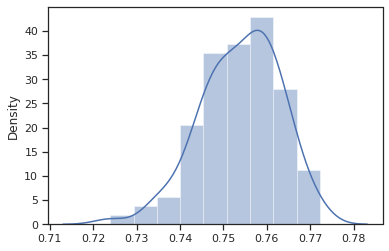

In [ ]:
# Distribucion, media y desvio de "todos_los_AUC_promedio"

print('Media: ', np.mean(todos_los_AUC_promedio)*100)
print('Desvio: ',np.std(todos_los_AUC_promedio)*100)
print('\n')
sns.distplot(todos_los_AUC_promedio)



In [ ]:
features = list(df.columns)
features.remove('metodo_anticonceptivo') # Saco la columna target
features.remove('religion_mujer') # No parece ser muy informativo pero no se si sacarlo
features.remove('educacion_hombre') # Puede estar explicada por nivel de vida (corr positiva) y exposicion a los medios (corr negativa)
features.remove('trabajo4') # Saco uno de las dummy para que no se pueda deducir una columna de las otras 3 (evito colinealidad)
# features.remove('exposicion_medios') #Negativamente correlacionada con exposicion a los medios
features

['edad_mujer',
 'educacion_mujer',
 'numero_hijos',
 'mujer_trabaja',
 'nivel_vida',
 'exposicion_medios',
 'trabajo1',
 'trabajo2',
 'trabajo3',
 'tiene_hijos']

El AUC promedio es:
0.7213114091790562


Text(0, 0.5, 'Folds')

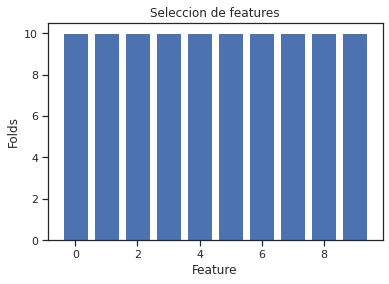

In [ ]:
# Seleccion de K Best

# Definamos la matriz X
X = df[features].values # Defino la variable X (los features). El método .values, me lleva la Serie de pandas a un array de numpy. 
y = df['metodo_anticonceptivo'] # Defino la variable y
# X = np.concatenate((X, X**2), axis=1) # agrego features elevados a potencias 

Kbest = 10 # los mejores K que voy a retener

skf = StratifiedKFold(n_splits=10, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values_fs =  []  # aca es donde van a ir a parar los indices de los features seleccionados en cada fold
selected_features= np.array([]).reshape(0,X.shape[1]) # aca es donde van a ir a parar los AUCs de cada fold. El reshape es para poder concatenar luego.


for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train)

    scaler = MinMaxScaler() # escaleo por separado ambos sets
    scaler.fit(X_test) 
    X_test = scaler.transform(X_test)

    selector = SelectKBest(k=Kbest) # por defecto, usa el F score de ANOVA y los Kbest features
    selector.fit(X_train, y_train) # encuentro los F scores 
    X_train_fs = selector.transform(X_train) # me quedo con los features mejor rankeados en el set de entrenamiento
    X_test_fs = selector.transform(X_test) # me quedo con los features mejor rankeados en el set de evaluacion
    features = np.array(selector.get_support()).reshape((1,-1)) # esto me pone True si la variable correspondiente fue seleccionada y False sino

    selected_features =  np.concatenate((selected_features,features),axis=0)

    regLog = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog.fit(X_train_fs, y_train) # Ajustamos el modelo con los datos de entrenamiento


    probas_test = regLog.predict_proba(X_test_fs)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación
    auc_values_fs.append(auc_test)

print('El AUC promedio es:')
print(np.mean(auc_values_fs))


import matplotlib.pyplot as plt

plt.bar(np.arange(0,X.shape[1]),np.sum(selected_features,axis=0))
plt.title('Seleccion de features')
plt.xlabel('Feature')
plt.ylabel('Folds')

### Confusion matrix

In [ ]:
features = list(df.columns)
features.remove('metodo_anticonceptivo') # Saco la columna target
features.remove('religion_mujer') # No parece ser muy informativo pero no se si sacarlo
features.remove('educacion_hombre') # Puede estar explicada por nivel de vida (corr positiva) y exposicion a los medios (corr negativa)
features.remove('trabajo4') # Saco uno de las dummy para que no se pueda deducir una columna de las otras 3 (evito colinealidad)
# features.remove('exposicion_medios') #Negativamente correlacionada con exposicion a los medios
features

['edad_mujer',
 'educacion_mujer',
 'numero_hijos',
 'mujer_trabaja',
 'nivel_vida',
 'exposicion_medios',
 'trabajo1',
 'trabajo2',
 'trabajo3',
 'tiene_hijos']

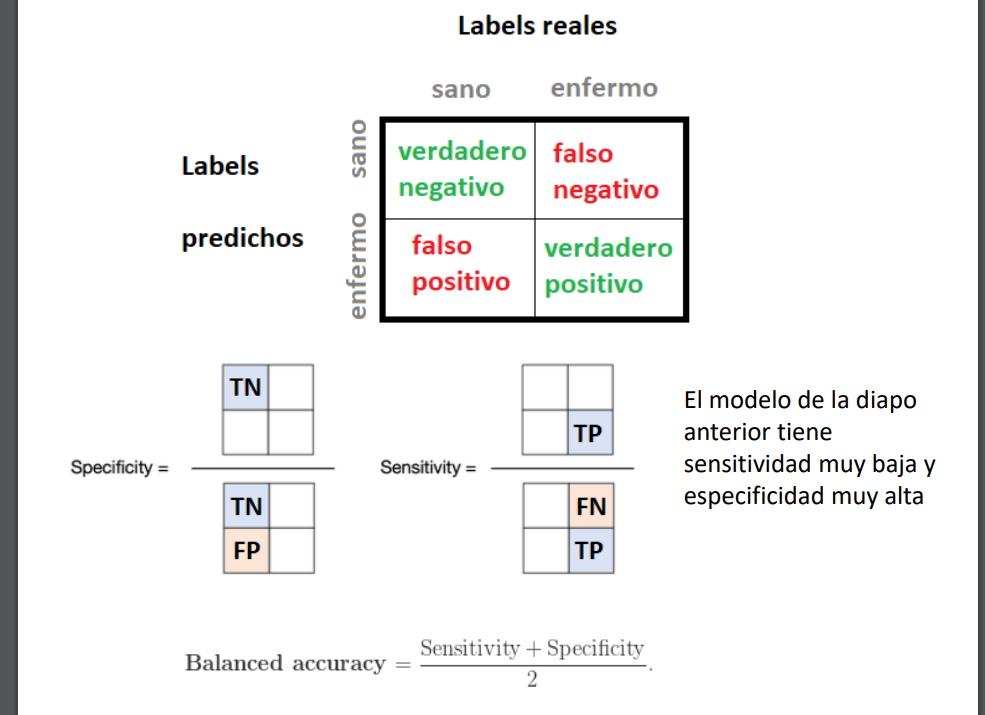

In [ ]:
# Por que me da mas alto el AUC aca? QUIZAS PORQUE NO SEPARE EN TRAIN Y TEST

### Grid search

In [ ]:
features

['edad_mujer',
 'educacion_mujer',
 'numero_hijos',
 'mujer_trabaja',
 'nivel_vida',
 'exposicion_medios',
 'trabajo1',
 'trabajo2',
 'trabajo3',
 'tiene_hijos']

In [ ]:
# Esto lo corri muchas veces, estos no son los valores finales que use

X = df[features].values # Defino la variable X (los features). El método .values, me lleva la Serie de pandas a un array de numpy. 
y = df['metodo_anticonceptivo'] # Defino la variable y


n_values = np.arange(1,5) # rango de potencias maximas 
c_values = np.arange(0.2,0.3,0.2) # rango de constantes de regularizacion

iterations = 100 # esto se puede poner en 100 para que no tarde mil años durante la clase

mean_AUC_train = np.zeros((len(n_values),len(c_values))) #  los arrays con los balanced accuracy para cada combinacion de hiperparametros, para train y test
mean_AUC_test = np.zeros((len(n_values),len(c_values)))

for xx,n in enumerate(n_values): # itero sobre n
    for yy,c in enumerate(c_values): # itero sobre c
      AUC_test_temp = [] # variables temporales para ir poniendo los resultados a lo largo de las iteraciones
      AUC_train_temp = []
      print([n,c]) # esto es para los ansiosos
      for it in np.arange(iterations): # itero
          AUC_train, AUC_test = classifier(X,y,n,c)  # calculo las balanced accuracy para esos hiperparametros
          AUC_test_temp.append(AUC_test) # agrego a las variables temporales
          AUC_train_temp.append(AUC_train)
      mean_AUC_train[xx,yy] = np.mean(AUC_train_temp) # calculo promedios
      mean_AUC_test[xx,yy] = np.mean(AUC_test_temp)

[1, 0.2]
[2, 0.2]
[3, 0.2]
[4, 0.2]


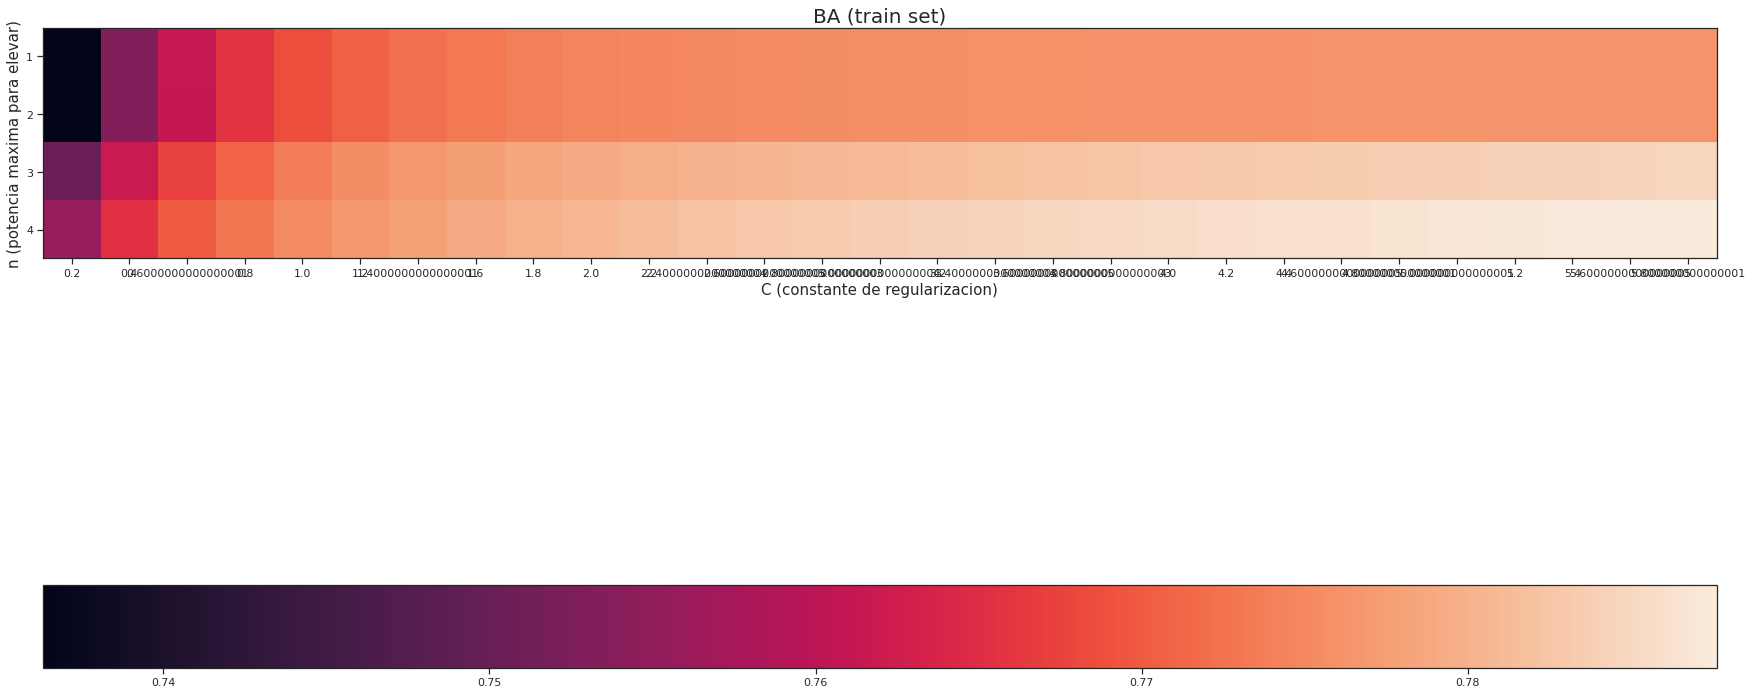

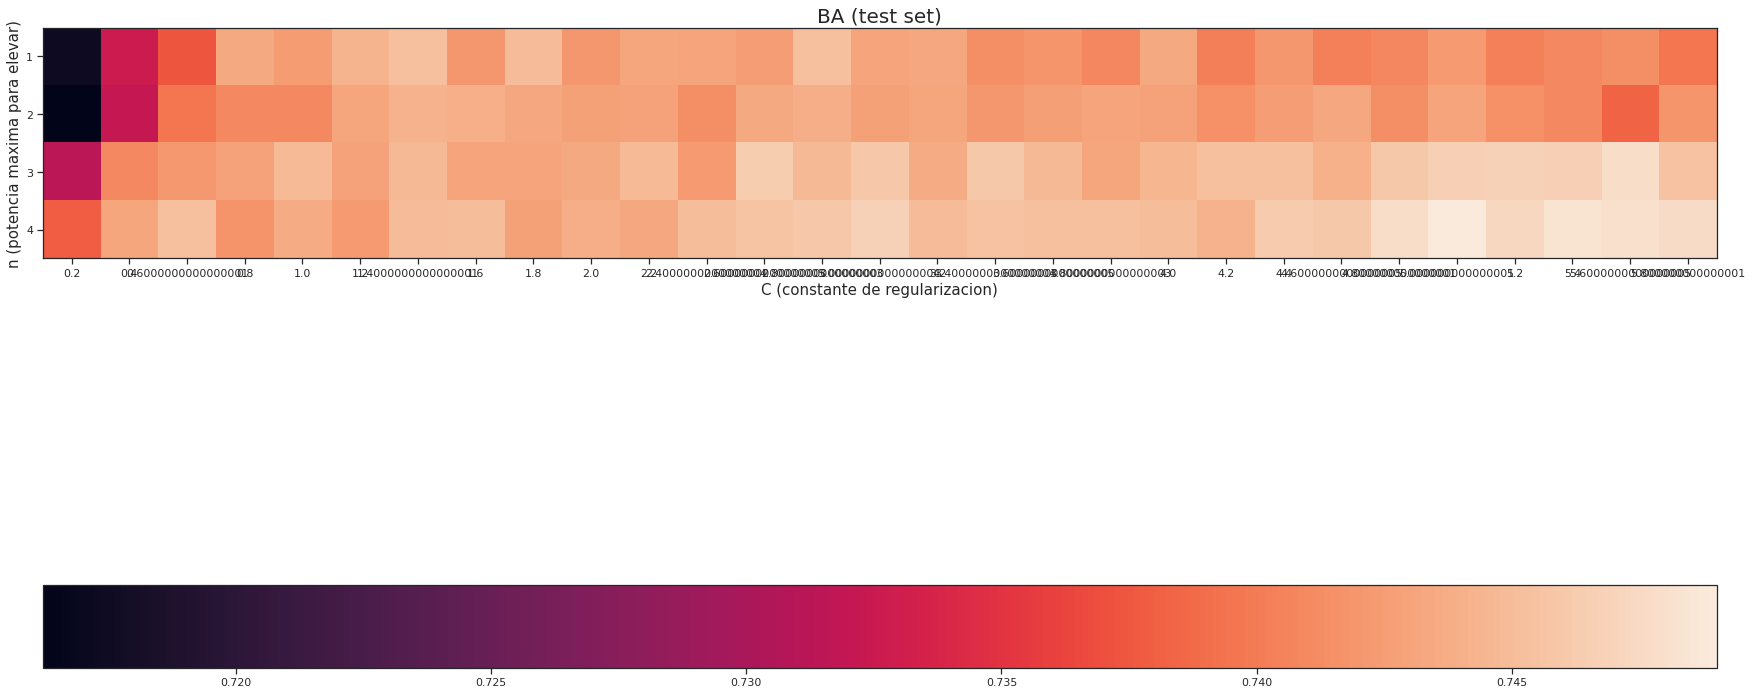

In [ ]:
# GRAFICO

fig, ax = plt.subplots(1,1, figsize=(30,30))  # visualizacion train set
img = ax.imshow(mean_AUC_train) # graficamos la matriz
y_label_list = n_values # estos son los ticks de los ejes
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list) # pongo los ticks de los ejes
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15) # le pongo nombre a ejes y titulo 
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (train set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig, ax = plt.subplots(1,1, figsize=(30,30)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_AUC_test)
y_label_list = n_values
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values)))
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15)
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (test set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2)

plt.show()

### Modelo final entrenado con todos los datos

In [ ]:
features = list(df.columns)
features.remove('metodo_anticonceptivo') # Saco la columna target
features.remove('religion_mujer') # No parece ser muy informativo pero no se si sacarlo
features.remove('educacion_hombre') # Puede estar explicada por nivel de vida (corr positiva) y exposicion a los medios (corr negativa)
features.remove('trabajo4') # Saco uno de las dummy para que no se pueda deducir una columna de las otras 3 (evito colinealidad)
# features.remove('exposicion_medios') #Negativamente correlacionada con exposicion a los medios
features

['edad_mujer',
 'educacion_mujer',
 'numero_hijos',
 'mujer_trabaja',
 'nivel_vida',
 'exposicion_medios',
 'trabajo1',
 'trabajo2',
 'trabajo3',
 'tiene_hijos']

AUC: 0.795


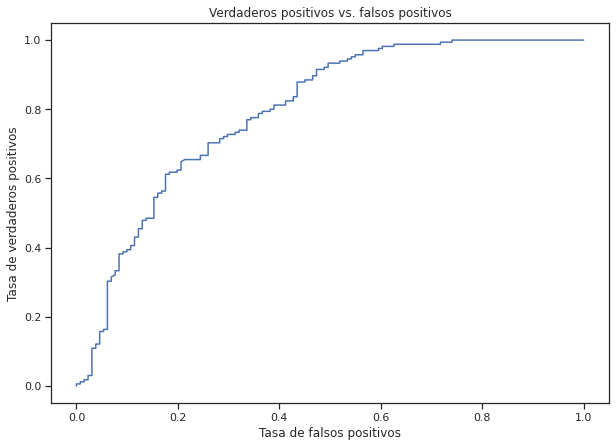

In [ ]:
X = df[features].values # Defino la variable X (los features). El método .values, me lleva la Serie de pandas a un array de numpy. 
y = df['metodo_anticonceptivo'] # Defino la variable y

X = np.concatenate((X, X**2), axis=1) # agrego features elevados a potencias

scaler = StandardScaler() # escaleo por separado ambos sets
scaler.fit(X) 
X = scaler.transform(X)

clasificador_final = LogisticRegression(penalty = 'l2',class_weight='balanced', max_iter=1000000, solver = 'sag', C=3.55) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
clasificador_final.fit(X, y) # Ajustamos el modelo con los datos de entrenamiento

probas = clasificador_final.predict_proba(X)  # probabilidades con datos de entrenamiento

fpr, tpr, thresholds = roc_curve(y, probas[:,1]) # para plotear curva ROC con datos de entrenamiento

auc_test = roc_auc_score(y, probas[:,1]) #  AUC con datos de evaluación

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr) # Gráfico de TPR vs FPR
ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

auc = roc_auc_score(y, probas[:,1]) # Cálculo del área debajo de la curva, recibe también las etiquetas verdaderas 
                                    # y la proba de que valgan 1.

print('AUC: {}'.format(round(auc,4))) # mostramos el AUC con 4 cifras significativas 


### Entrega

**Hasta acá es lo que Uds. tienen hecho, obviamente con su propio modelo**

Lo que viene a continuación es lo que tienen que hacer para enviarnos sus predicciones. 

Primero, tienen que cargar el archivo anticoncepcion_indonesia_test.csv que está en el drive (recuerden, si es necesario, crearse un acceso directo, como siempre).

In [ ]:
path = '/content/drive/My Drive/LaboDatos2021/anticoncepcion_indonesia_test.csv'
df_test = pd.read_csv(path)
df_test.columns

Index(['edad_mujer', 'educacion_mujer', 'educacion_hombre', 'numero_hijos',
       'religion_mujer', 'mujer_trabaja', 'ocupacion_hombre', 'nivel_vida',
       'exposicion_medios'],
      dtype='object')

Vemos que obviamente falta la columna que queremos predecir.


Ahora, Uds. arman la matriz de features tal como la construyeron para su modelo, incluyendo la selección que hayan armado, o el agregado de nuevos features, etc. En nuestro ejemplo es simplemente agarrar todas las columnas.

In [ ]:
df_test.shape

(1177, 9)

In [ ]:
df_test

,edad_mujer,educacion_mujer,educacion_hombre,numero_hijos,religion_mujer,mujer_trabaja,ocupacion_hombre,nivel_vida,exposicion_medios
0,30,2,3,1,1,1,2,1,0
1,31,3,4,0,1,0,2,3,0
2,23,1,2,3,1,1,3,2,1
3,46,1,2,3,1,1,2,1,1
4,36,4,4,3,1,1,1,4,0
5,32,2,2,2,1,1,2,4,0
6,49,2,3,4,1,1,2,3,0
7,47,4,4,4,0,1,2,4,0
8,29,4,4,2,1,0,1,3,0
9,43,2,4,13,1,1,2,3,0


In [ ]:
# One hot encoding en la ocupacion del hombre
# No se si conviene usar esto o el metodo de sklearn [REVISARRRRRRRR] !!!
dummy_test = pd.get_dummies(df_test.ocupacion_hombre)
dummy_test.columns = ['trabajo1','trabajo2','trabajo3','trabajo4']
# LO junto con el df original
df_test = pd.concat([df_test,dummy_test], axis='columns')

# Dropeo la columna que separe en dummies
df_test.drop('ocupacion_hombre',axis=1,inplace = True)

In [ ]:
# Nuevo feature : tiene_hijos , feature binario con 1 si tiene y 0 si no tiene
df_test['tiene_hijos']= (df_test['numero_hijos'] != 0).astype('int')

In [ ]:
features_test = list(df_test.columns)
features_test.remove('religion_mujer') # No parece ser muy informativo pero no se si sacarlo
features_test.remove('educacion_hombre') # Puede estar explicada por nivel de vida (corr positiva) y exposicion a los medios (corr negativa)
features_test.remove('trabajo4') # Saco uno de las dummy para que no se pueda deducir una columna de las otras 3
# features.remove('exposicion_medios') #Negativamente correlacionada con exposicion a los medios
features_test

['edad_mujer',
 'educacion_mujer',
 'numero_hijos',
 'mujer_trabaja',
 'nivel_vida',
 'exposicion_medios',
 'trabajo1',
 'trabajo2',
 'trabajo3',
 'tiene_hijos']

In [ ]:
X_test_final = df_test[features_test].values # Defino la variable X (los features). El método .values, me lleva la Serie de pandas a un array de numpy. 
X_test_final = np.concatenate((X_test_final, X_test_final**2), axis=1) # agrego features elevados a potencias


In [ ]:
X_test_final.shape

(1177, 20)

In [ ]:
df_test.shape

(1177, 13)

In [ ]:
# escaleo 
scaler_test = StandardScaler() 
scaler_test.fit(X_test_final) 
X_test_final = scaler.transform(X_test_final)

Luego, predecimos las **probabilidades** (no las etiquetas binarias) usando el 

modelo que entrenamos.

In [ ]:
probas_final = clasificador_final.predict_proba(X_test_final)
print(probas_final)

[[8.35367328e-01 1.64632672e-01]
 [9.99021341e-01 9.78658557e-04]
 [6.51513145e-01 3.48486855e-01]
 ...
 [9.55953426e-01 4.40465738e-02]
 [9.21825103e-01 7.81748969e-02]
 [7.50014249e-01 2.49985751e-01]]


In [ ]:
probas_final.shape

(1177, 2)

**La matriz de dos columnas que obtenemos de output es lo que hay que entregar.**

Para hacerlo, guardamos en algún drive un archivo csv con esto, luego lo bajamos, y lo mandamos por mail al profesor (o sea, a mi) a tagliazucchi.enzo@googlemail.com, con el titulo "Entrega segundo TP" y el adjunto correspondiente. **Por favor, que el adjunto tenga su nombre y apellido.**

En mi caso, como tengo acceso a la carpeta del Labo de datos, lo guardo simplemente ahí y luego lo bajo.

In [ ]:
save_path= '/content/drive/My Drive/Gustavo_Juantorena.csv' # acá uds. van a tener que poner un directorio suyo en drive, porque no tienen permisos de escribir en el directorio LaboDatos2021

np.savetxt(save_path, probas_final, delimiter=",")